# Homework 1
- Author: Ryan Kingery
- Course: ECE 5554 - Computer Vision
- Instructor: Dr. Jia-Bin Huang

In [6]:
%matplotlib inline
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image
from scipy.signal import get_window
from scipy.ndimage import correlate, sobel
from skimage import filters, feature
from scipy.ndimage import gaussian_filter

In [7]:
data_path = '/Users/ryankingery/Repos/computer-vision-course/data/hw1/data/'
#edge_data_path = '/Users/ryankingery/Repos/computer-vision-course/data/hw1/prob_edge/data/'

In [8]:
def vis_hybrid_image(hybrid_image):
    hybrid_image = (normalize(hybrid_image)*255).astype(np.uint8)
    scales = 5
    scale_factor = 0.5
    padding = 5
    original_height = hybrid_image.shape[0]
    num_colors = hybrid_image.shape[2]
    output = hybrid_image
    cur_image = hybrid_image
    for i in range(1,scales):
        output = np.hstack([output,np.ones((original_height,padding,num_colors))])
        scaled_size = (int(cur_image.shape[1]*scale_factor),int(cur_image.shape[0]*scale_factor))
        #cur_image = np.array(Image.fromarray(cur_image).resize(scaled_size, Image.BILINEAR))
        cur_image = cv2.resize(cur_image, dsize=scaled_size, interpolation=cv2.INTER_LINEAR)
        tmp = np.vstack([np.ones((original_height-cur_image.shape[0],cur_image.shape[1],
                                 num_colors)), cur_image])
        output = np.hstack([output,tmp])
    return output.astype(int)

def plot_image(image,title=None,figsize=(5,5),cmap=None):
    _, ax = plt.subplots(figsize=figsize)
    image = normalize(image)
    ax.imshow(image, cmap=cmap)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    plt.show()

def gaussian_filter_rgb(image,sigma):
    output = []
    for c in range(image.shape[2]):
        tmp = gaussian_filter(image[:,:,c],sigma=sigma)
        output.append(tmp)
    output = np.stack(output, axis=2).astype(int)
    return output

def normalize(image, to='0-1'):
    image = np.array(image)
    normed = (image-image.min())/(image.max()-image.min())
    if to=='0-1':
        return normed
    if to=='0-255':
        return (normed*255).astype(np.uint8)
    
def log_fourier(image):
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    logfft = np.log(np.abs(np.fft.fftshift(np.fft.fft2(image))))
    return logfft

def gradient_magnitude(image, sigma):
    image = gaussian_filter_rgb(image,sigma)
    gx = sobel(image,axis=0,mode='constant')
    gy = sobel(image,axis=1,mode='constant')
    magnitude = np.sqrt(gx**2+gy**2)
    ggx,ggy = np.zeros((image.shape[0],image.shape[1])),np.zeros((image.shape[0],image.shape[1]))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            c = np.argmax(magnitude[i,j,:])
            ggx[i,j] = gx[i,j,c]
            ggy[i,j] = gy[i,j,c]
    theta = np.arctan2(ggy,ggx)
    magnitude = np.sqrt(np.sum(magnitude**2,axis=2))
    return magnitude,theta

def edge_gradient(image, sigma=2.5):
    magnitude,theta = gradient_magnitude(image, sigma)
    magnitude *= 0.7
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = feature.canny(image).astype(np.uint8)*255
    bmap = magnitude*edges
    bmap[np.abs(magnitude)<1e-6] = 0
    return bmap

def oriented_filter_magnitude(image):
    pass

def edge_oriented_filters(image):
    pass

## Problem 1: Hybrid Image

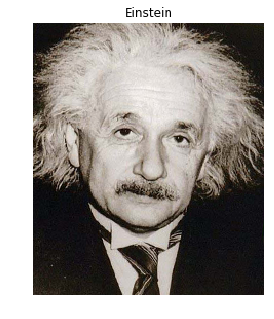

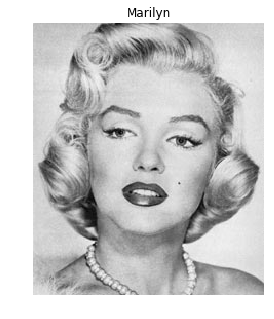

In [9]:
image1 = imageio.imread(data_path+'einstein.bmp')
image2 = imageio.imread(data_path+'marilyn.bmp')
plot_image(image1,'Einstein')
plot_image(image2,'Marilyn')

In [10]:
low_freqs = gaussian_filter_rgb(image1,1)
high_freqs = image2 - gaussian_filter_rgb(image2,7)
hybrid_image = normalize(low_freqs+high_freqs,to='0-255')

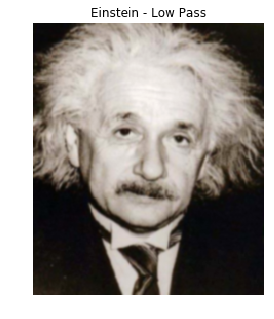

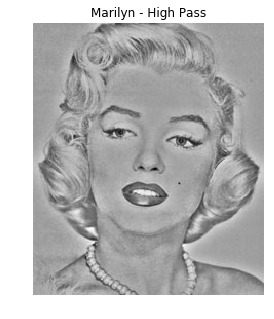

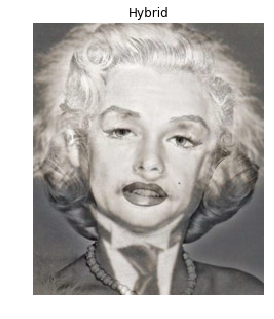

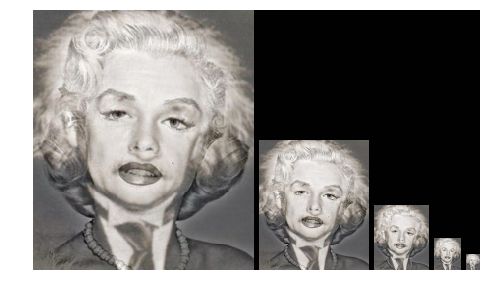

In [11]:
plot_image(low_freqs, 'Einstein - Low Pass')
plot_image(high_freqs, 'Marilyn - High Pass')
plot_image(hybrid_image, 'Hybrid')
plot_image(vis_hybrid_image(hybrid_image),figsize=(8,8))

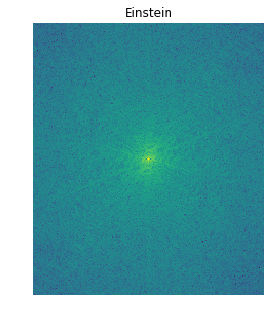

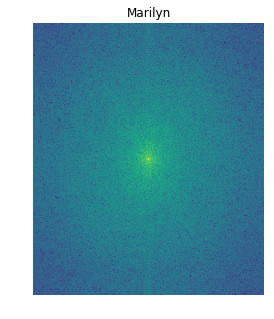

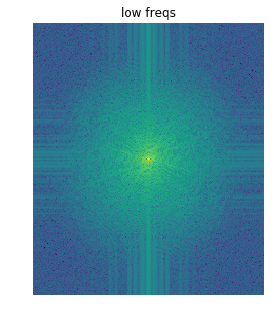

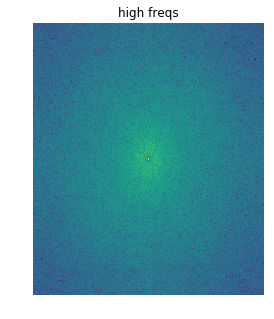

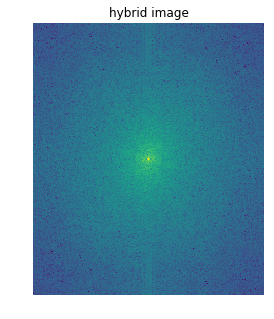

In [12]:
plot_image(log_fourier(image1), 'Einstein')
plot_image(log_fourier(image2), 'Marilyn')

low_freqs = normalize(low_freqs,to='0-255')
high_freqs = normalize(high_freqs,to='0-255')
plot_image(log_fourier(low_freqs), 'low freqs')
plot_image(log_fourier(high_freqs), 'high freqs')

plot_image(log_fourier(hybrid_image), 'hybrid image')

## Problem 2: Image Pyramid

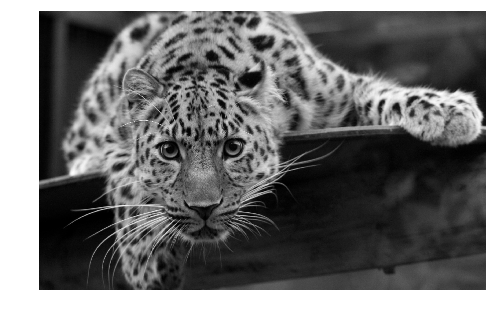

In [13]:
image = imageio.imread(data_path+'leopard.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plot_image(image,figsize=(8,8),cmap=cm.gray)

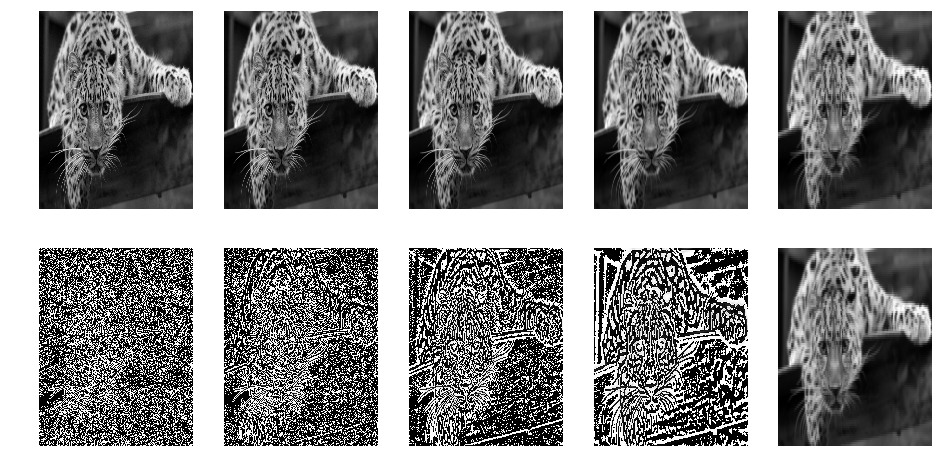

In [14]:
levels = 4
img = image.copy()
gaussian_pyramid = [img]
for i in range(0,levels):
    img = cv2.pyrDown(img)
    gaussian_pyramid.append(img)

laplacian_pyramid = [gaussian_pyramid[-1]]    
for i in range(levels,0,-1):
    img = cv2.pyrUp(gaussian_pyramid[i])
    lap = gaussian_pyramid[i-1] - img
    laplacian_pyramid.append(lap)
laplacian_pyramid.reverse()

concat = gaussian_pyramid + laplacian_pyramid
plt.subplots(2,levels+1,figsize=(16,8))
for i in range(len(concat)):
    plt.subplot(2,len(concat)//2,i+1)
    plt.imshow(concat[i], cmap=cm.gray, aspect='auto')
    plt.axis('off')
plt.show()

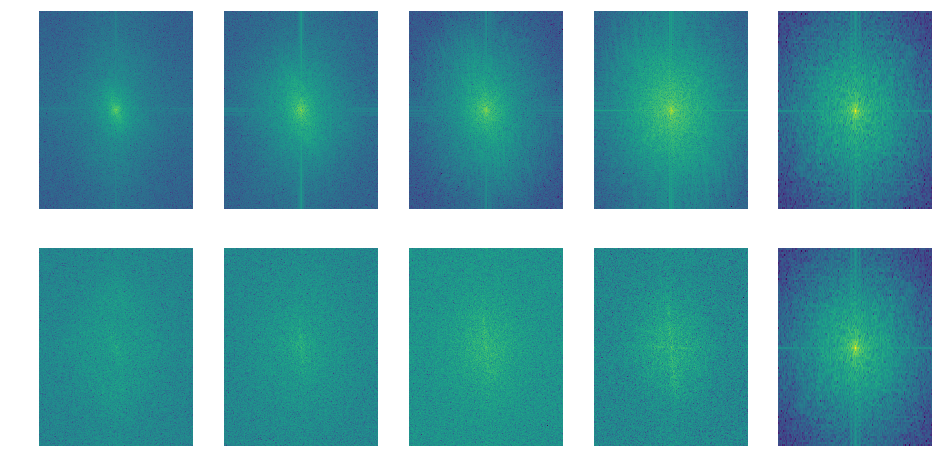

In [15]:
plt.subplots(2,levels+1,figsize=(16,8))
for i in range(len(concat)):
    plt.subplot(2,len(concat)//2,i+1)
    plt.imshow(log_fourier(concat[i]), aspect='auto')
    plt.axis('off')
plt.show()

## Problem 3: Edge Detection

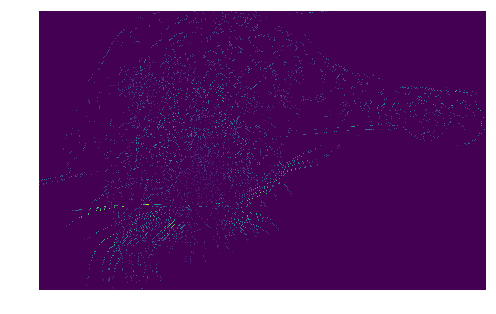

In [16]:
image = imageio.imread(data_path+'leopard.jpg')
sigma = 2.5
bmap = edge_gradient(image, sigma)
plot_image(bmap, figsize=(8,8))